# Ticket inspection AI

## Imports

In [89]:
import random
import xgboost as xgb
import pandas as pd
import numpy as np

import optuna as opt
from sdv.tabular import GaussianCopula
from sdv.evaluation import evaluate

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report, mean_squared_error

import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

## Functions

In [90]:
def strCleaner(x: str) -> str:
    x = x.lower()
    x = x.replace(" ", "_")

    if "ja" in x:
        return "ja"

    return x


def clockTofloat(x: str) -> float:
    x = x[:-3]
    x = x.replace(":",".")
    x = float(x)
    return x

def extractHour(x):
    return x.hour

def extractMinute(x):
    return x.minute

def findCatCode(l, x: str) -> int:
    for i in range(len(l)):
        if l[i] == x:
            code = l.codes[i]
            return code
        
def datetimeToInt(dt) -> int:
    # second = dt.second
    minute = dt.minute*1
    hour = dt.hour*10
    day = dt.day*10000
    month = dt.month*1000000
    year = dt.year*100000000
    
    ret = minute+hour+day+month+year
    return ret

def extractDay(dt):
    return dt.day
    
def extractMonth(dt):
    return dt.month

def extractYear(dt):
    return dt.year

## Reading data

In [91]:
#db = pd.read_excel("/Users/sigurdskyrud/OneDrive/Dokumenter/Andre Dokumenter/Billettkontroll data.xlsx")
db = pd.read_excel('C:/Users/sigzu/OneDrive/Dokumenter/Andre Dokumenter/Billettkontroll data.xlsx')

db.head(2)

,Linje,Vogn,Dato,Klokke,Fra,Til,Fullt?,Sjekket?,Merknad
0,L12,Fremst,2022-09-25,11:30:00,Eidsvoll,Oslo Lufthavn,Nei,Nei,NaN
1,R10,Bakerst,2022-09-25,21:59:00,Oslo Lufthavn,Eidsvoll,Ja,Ja,NaN


In [92]:
db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52 entries, 0 to 51
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Linje     52 non-null     object        
 1   Vogn      52 non-null     object        
 2   Dato      52 non-null     datetime64[ns]
 3   Klokke    52 non-null     object        
 4   Fra       52 non-null     object        
 5   Til       52 non-null     object        
 6   Fullt?    52 non-null     object        
 7   Sjekket?  52 non-null     object        
 8   Merknad   4 non-null      object        
dtypes: datetime64[ns](1), object(8)
memory usage: 3.8+ KB


# Data cleaning and engineering

## Categorize the features

In [93]:
db["Fullt?"] = db["Fullt?"].apply(lambda x: strCleaner(x))
fulltCat = pd.Categorical(db["Fullt?"])
db["Fullt?"] = pd.Categorical(db["Fullt?"]).codes

db["Sjekket?"] = db["Sjekket?"].apply(lambda x: strCleaner(x))
sjekketCat = pd.Categorical(db["Sjekket?"])
db["Sjekket?"] = pd.Categorical(db["Sjekket?"]).codes

db["Linje"] = db["Linje"].apply(lambda x: strCleaner(x))
linjeCat = pd.Categorical(db["Linje"])
db["Linje"] = pd.Categorical(db["Linje"]).codes

db["Fra"] = db["Fra"].apply(lambda x: strCleaner(x))
fraCat = pd.Categorical(db["Fra"])
db["Fra"] = pd.Categorical(db["Fra"]).codes

db["Til"] = db["Til"].apply(lambda x: strCleaner(x))
tilCat = pd.Categorical(db["Til"])
db["Til"] = pd.Categorical(db["Til"]).codes

Vogn needs to be converted to a string

In [94]:
db["Vogn"] = pd.Series(db["Vogn"], dtype="string")
db["Vogn"] = db["Vogn"].apply(lambda x: strCleaner(x))

vognCat = pd.Categorical(db["Vogn"])
db["Vogn"] = pd.Categorical(db["Vogn"]).codes

Merknad needs to convert all empty values to -1

In [95]:
db["Merknad"].fillna(-1)

merknadCat = pd.Categorical(db["Merknad"])
db["Merknad"] = pd.Categorical(db["Merknad"]).codes

In [96]:
fraCat

['eidsvoll', 'oslo_lufthavn', 'eidsvoll', 'nationaltheatret', 'eidsvoll', ..., 'nationaltheatret', 'eidsvoll', 'nationaltheatret', 'eidsvoll', 'oslo_lufthavn']
Length: 52
Categories (5, object): ['eidsvoll', 'nationaltheatret', 'oslo_lufthavn', 'oslo_s', 'skarnes']

Extract date sub-categories

In [97]:
# db['Dato'] = (db['Dato'] - db['Dato'].min())  / np.timedelta64(1,'D')
# db["Dato"] = db["Dato"].apply(lambda x: datetimeToInt(x))
# db["Dato"].head(3)

In [98]:
db["Dag"] = db["Dato"].apply(lambda x: extractDay(x))
db["Måned"] = db["Dato"].apply(lambda x: extractMonth(x))
# db["År"] = db["Dato"].apply(lambda x: extractYear(x)) # Not relevant for the timescale I have

db = db.drop("Dato", axis=1)
db.head(3)

,Linje,Vogn,Klokke,Fra,Til,Fullt?,Sjekket?,Merknad,Dag,Måned
0,1,1,11:30:00,0,3,1,1,-1,25,9
1,3,0,21:59:00,2,0,0,0,-1,25,9
2,1,1,09:30:00,0,2,0,1,-1,26,9


Exctract time sub-categories

In [99]:
# db["Klokke"] = pd.Series(db["Klokke"], dtype="str")
# db["Klokke"] = db["Klokke"].apply(lambda x: clockTofloat(x))

In [100]:
db["Time"] = db["Klokke"].apply(lambda x: extractHour(x))
db["Minutt"] = db["Klokke"].apply(lambda x: extractMinute(x))

db = db.drop("Klokke", axis=1)
db.head(3)

,Linje,Vogn,Fra,Til,Fullt?,Sjekket?,Merknad,Dag,Måned,Time,Minutt
0,1,1,0,3,1,1,-1,25,9,11,30
1,3,0,2,0,0,0,-1,25,9,21,59
2,1,1,0,2,0,1,-1,26,9,9,30


In [101]:
db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52 entries, 0 to 51
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   Linje     52 non-null     int8 
 1   Vogn      52 non-null     int8 
 2   Fra       52 non-null     int8 
 3   Til       52 non-null     int8 
 4   Fullt?    52 non-null     int8 
 5   Sjekket?  52 non-null     int8 
 6   Merknad   52 non-null     int8 
 7   Dag       52 non-null     int64
 8   Måned     52 non-null     int64
 9   Time      52 non-null     int64
 10  Minutt    52 non-null     int64
dtypes: int64(4), int8(7)
memory usage: 2.1 KB


<AxesSubplot: >

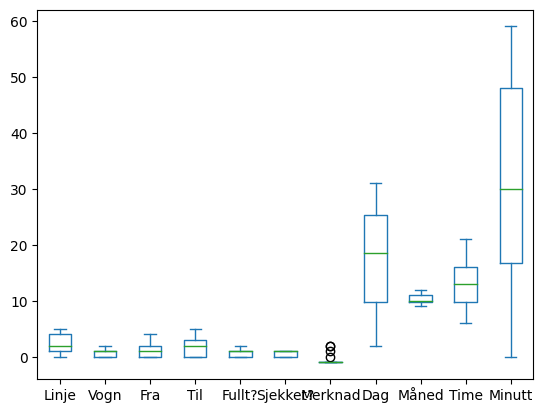

In [102]:
db.plot.box()

# Synthetic data

In [103]:
sdv = GaussianCopula()
sdv.fit(db)
sample = sdv.sample(500)
sample.head(3)

,Linje,Vogn,Fra,Til,Fullt?,Sjekket?,Merknad,Dag,Måned,Time,Minutt
0,2,1,0,1,2,1,-1,22,10,13,12
1,1,1,0,1,0,0,0,30,11,11,34
2,0,1,4,0,1,0,0,22,10,20,57


In [104]:
# Dont work
evaluate(sample, db, metrics=['CSTest'], aggregate=False)

,metric,name,raw_score,normalized_score,min_value,max_value,goal,error
0,CSTest,Chi-Squared,None,None,0.0,1.0,MAXIMIZE,"Cannot find fields of types ('boolean', 'categ..."


In [105]:
db = pd.concat([db, sample])

# Creating testing data

In [137]:
# Create the data to create predict from
X = db.drop(["Sjekket?"], axis=1)

# Create the data to predict to
y = db["Sjekket?"]

# Merknad has gives no impact on result
X = X.drop(["Merknad"], axis=1)

### Testing without clock
# X = X.drop(["Klokke"], axis=1)

X.head(3)

# Train_test_split

In [109]:
# Split the data into train and test sets with test_size=0.2 and random_state=42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating model1 - XGBoostClassifier

In [110]:
model = xgb.XGBClassifier()
model.fit(X_train, y_train)

[16:16:08] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\Users\sigzu\miniconda3\envs\billettkontroll\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\Users\sigzu\miniconda3\envs\billettkontroll\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=16,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [111]:
preds = model.predict(X_test)

## Model 1 testing

### Model 1's confusion matrix

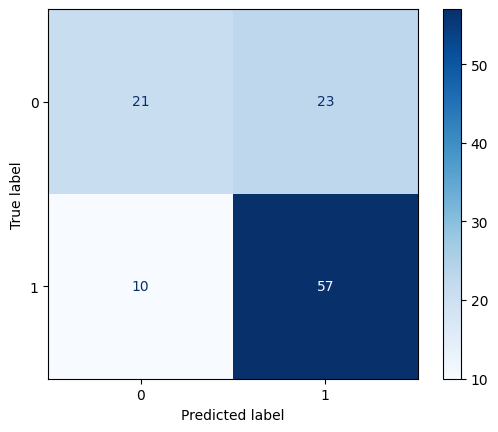

In [112]:
cm = confusion_matrix(y_true=y_test, y_pred=preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)

disp.plot(cmap='Blues')

In [113]:
accuracy = accuracy_score(y_true=y_test, y_pred=preds)
print(f"Accuracy: {accuracy * 100.0 : .2f}")

Accuracy:  70.27


### Model 1's feature importance

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

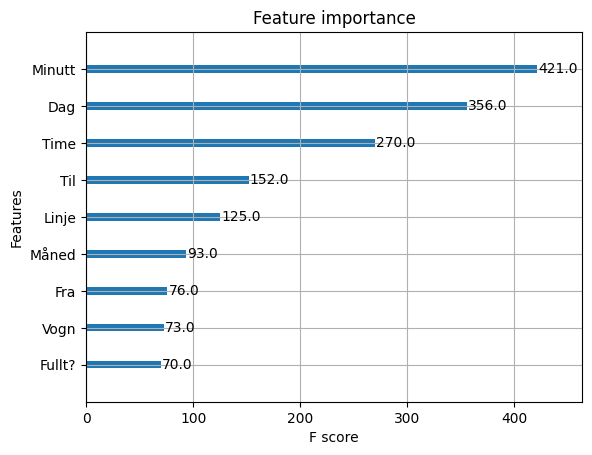

In [114]:
xgb.plot_importance(model)

# Creating model 2 - Model 1 with optuna

In [115]:
def objective(trial):
    """Define the objective function"""

    params = {
        'max_depth': trial.suggest_int('max_depth', 0, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'min_child_weight': trial.suggest_int('min_child_weight', 0, 10),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1e+3),
        'subsample': trial.suggest_loguniform('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
        'eval_metric': 'mlogloss',
        'use_label_encoder': False
    }

    # Fit the model
    optuna_model = xgb.XGBClassifier(**params)
    optuna_model.fit(X_train, y_train)

    # Make predictions
    y_pred = optuna_model.predict(X_test)

    # Evaluate predictions
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

study = opt.create_study(direction="maximize")
study.optimize(objective, n_trials=250)

[I 2022-12-16 16:16:08,656] A new study created in memory with name: no-name-d2792eca-0967-4fc5-a9ba-9149a9430eea
C:\Users\sigzu\AppData\Local\Temp\ipykernel_25772\3685673603.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
C:\Users\sigzu\AppData\Local\Temp\ipykernel_25772\3685673603.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'gamma': trial.suggest_loguniform('gamma', 1e-8, 1e+3),
C:\Users\sigzu\AppData\Local\Temp\ipykernel_25772\3685673603.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://

In [116]:
bparams = study.best_params
model2 = xgb.XGBClassifier(**bparams)
model2.fit(X_train, y_train)

c:\Users\sigzu\miniconda3\envs\billettkontroll\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\Users\sigzu\miniconda3\envs\billettkontroll\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:16:33] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.015289057379003466,
              enable_categorical=False, gamma=0.00017811174606059625, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.17059042135602356, max_delta_step=0, max_depth=10,
              min_child_weight=9, missing=nan, monotone_constraints='()',
              n_estimators=224, n_jobs=16, num_parallel_tree=1,
              predictor='auto', random_state=0,
              reg_alpha=4.0755820040658766e-08,
              reg_lambda=2.605414839784691e-05, scale_pos_weight=1,
              subsample=0.4799969626111665, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [117]:
preds2 = model2.predict(X_test)

## Model 2 testing

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

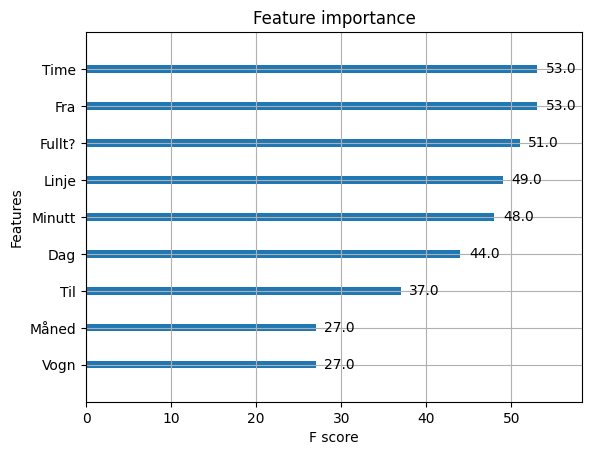

In [118]:
xgb.plot_importance(model2)

### Model 2 Confusion Matrix

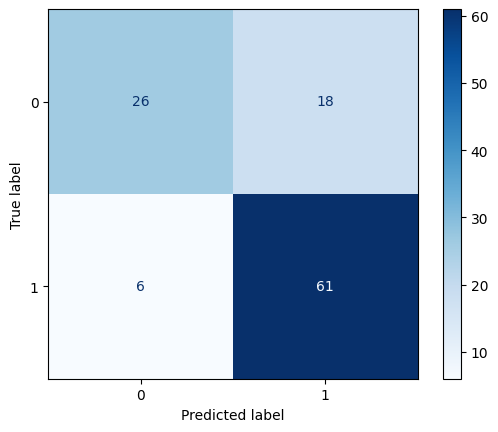

In [119]:
cm = confusion_matrix(y_true=y_test, y_pred=preds2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model2.classes_)

disp.plot(cmap='Blues')

In [120]:
accuracy2 = accuracy_score(y_true=y_test, y_pred=preds2)
print(f"Accuracy: {accuracy2 * 100.0 : .2f}")

Accuracy:  78.38


# Model 3 - Logistic regression

In [121]:
model3 = LogisticRegression(solver='liblinear', random_state=42)
model3.fit(X_train, y_train)
preds3 = model3.predict(X_test)


## Model 3 testing

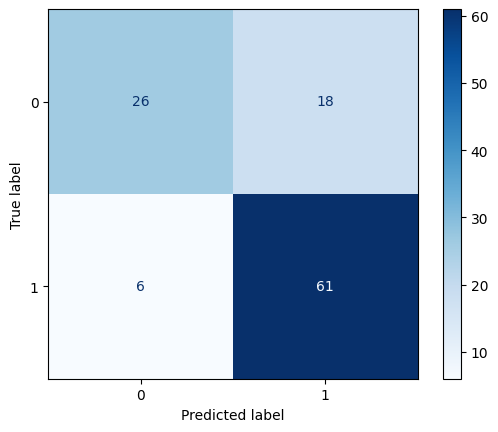

In [122]:
cm = confusion_matrix(y_true=y_test, y_pred=preds3)

ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model3.classes_)

disp.plot(cmap='Blues')

In [123]:
print(model3.score(X_test, y_test))
accuracy3 = accuracy_score(y_true=y_test, y_pred=preds3)
print(f"Accuracy: {accuracy3 * 100.0 : .2f}")

0.7207207207207207
Accuracy:  72.07


In [124]:
print(classification_report(y_test, preds3))

              precision    recall  f1-score   support

           0       0.72      0.48      0.58        44
           1       0.72      0.88      0.79        67

    accuracy                           0.72       111
   macro avg       0.72      0.68      0.68       111
weighted avg       0.72      0.72      0.71       111



# Model 4 - Logistic regression with optuna

In [125]:
heyho = {'hello': 'hi'}

if 'hello' in heyho:
    index = list(heyho.values())[0]

print(index)

hi


In [126]:
def check_value_exist(dict: dict, liste: list) -> bool:
    do_exist = False
    for l in liste:
            for key, val in dict.items():
                if val == l:
                    do_exist = True
    return do_exist

In [127]:
def objective(trial):
    """
    Tests parameters for sciKit LogicalRegression
    """


    # Cant use suggest_categorical for multiple strings. Crashes
    # Tried with setting string values from random list number, dont work
    # CANT ACTUALLY SET STRING VALUES WIHTOUT USING CATEGORICAL, and that not workign with multiple
    # Solver
    # solver_num = random.randint(0, 4)
    # solver_list = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
    solver = 'liblinear' # solver_list[solver_num]
    # fit_intercept
    # fit_num = trial.suggest_int('fit_num', 0, 1)

    params = {
        'tol': trial.suggest_float('tol', 1e-5, 1e-1),
        'C': trial.suggest_float('C', 0.0, 1.0),
        'fit_intercept': trial.suggest_categorical('fit_intercept', [True, False]),
        'random_state': trial.suggest_int('random_state', 0, 50),
        'intercept_scaling': trial.suggest_float('intercept_scaling', 0, 1.0),
        'solver': trial.suggest_categorical('solver', [solver]),
        'max_iter': trial.suggest_int('max_iter', 0, 60)
    }

    # Pentalty
    #if check_value_exist(params, ['newton-cg', 'lbfgs', 'sag']):
    #    number = random.randint(0, 1)
    #    if number == 1:
    #        params.update({'penalty': trial.suggest_categorical('penalty', ["l2"])})
    #    else:
    #        params.update({'penalty': trial.suggest_categorical('penalty', ["none"])})
    #elif check_value_exist(params, ['liblinear']):
    #number = random.randint(0, 1)
    #if number == 1:
    params.update({'penalty': trial.suggest_categorical('penalty', ["l1", "l2"])}) # l1 sucks with liblinear, dont use
    #else:
    #    params.update({'penalty': trial.suggest_categorical('penalty', ["l2"])})
    #elif check_value_exist(params, ['saga']):
    #    number = random.randint(0, 3)
    #    if number == 0:
    #        params.update({'penalty': trial.suggest_categorical('penalty', ["elasticnet"])})
    #    elif number == 1:
    #        params.update({'penalty': trial.suggest_categorical('penalty', ["l2"])})
    #    elif number == 2:
    #        params.update({'penalty': trial.suggest_categorical('penalty', ["l1"])})  
    #    else:
    #        params.update({'penalty': trial.suggest_categorical('penalty', ["none"])}) 

    # l1_ratio //sucks balls man
    if check_value_exist(params, ['l1', 'elasticnet']):
        params.update({'l1_ratio': trial.suggest_float('l1_ratio', 0.0, 1.0)})

    # Dual
    if check_value_exist(params, ['l2']) and check_value_exist(params, ['liblinear']):
        params.update({'dual': trial.suggest_categorical('dual', [True, False])})
    #else:
    #    params.update({'dual': trial.suggest_categorical('dual', [False])})

    # Fit the model
    optuna_model = LogisticRegression(**params)
    optuna_model.fit(X_train, y_train)

    # Make predictions
    y_pred = optuna_model.predict(X_test)

    # Evaluate predictions
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

study = opt.create_study(direction="maximize")
study.optimize(objective, n_trials=500)

[I 2022-12-16 16:16:33,927] A new study created in memory with name: no-name-51ed0a06-a19b-4208-826c-8255a21e8d6e
[I 2022-12-16 16:16:33,933] Trial 0 finished with value: 0.7117117117117117 and parameters: {'tol': 0.053463121327651145, 'C': 0.5295487791532782, 'fit_intercept': False, 'random_state': 40, 'intercept_scaling': 0.6044532199787676, 'solver': 'liblinear', 'max_iter': 60, 'penalty': 'l2', 'dual': False}. Best is trial 0 with value: 0.7117117117117117.
[I 2022-12-16 16:16:33,937] Trial 1 finished with value: 0.7117117117117117 and parameters: {'tol': 0.07500166397493624, 'C': 0.7590480227015638, 'fit_intercept': True, 'random_state': 31, 'intercept_scaling': 0.7799364927113367, 'solver': 'liblinear', 'max_iter': 44, 'penalty': 'l2', 'dual': False}. Best is trial 0 with value: 0.7117117117117117.
c:\Users\sigzu\miniconda3\envs\billettkontroll\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warni

In [128]:
bparams = study.best_params
model4 = LogisticRegression(**bparams)
model4.fit(X_train, y_train)
preds4 = model4.predict(X_test)
bparams

c:\Users\sigzu\miniconda3\envs\billettkontroll\lib\site-packages\sklearn\linear_model\_logistic.py:1106: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


{'tol': 0.004666095582500024,
 'C': 0.09527752720192961,
 'fit_intercept': True,
 'random_state': 8,
 'intercept_scaling': 0.49405149865970877,
 'solver': 'liblinear',
 'max_iter': 43,
 'penalty': 'l1',
 'l1_ratio': 0.10580020887265082}

## Model 4 testing

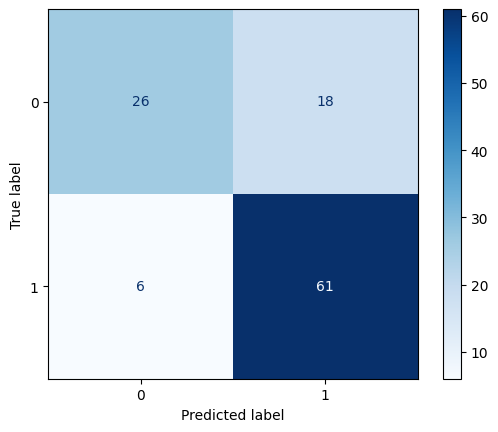

In [129]:
cm = confusion_matrix(y_true=y_test, y_pred=preds4)

ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model4.classes_)

disp.plot(cmap='Blues')

In [130]:
print(model4.score(X_test, y_test))
accuracy4 = accuracy_score(y_true=y_test, y_pred=preds4)
print(f"Accuracy: {accuracy4 * 100.0 : .2f}")

0.7477477477477478
Accuracy:  74.77


# Best

In [131]:
accuracies = [accuracy, accuracy2, accuracy3, accuracy4]

counter = 1
score = 0
for a in accuracies:
    if a > score:
        best = counter
        score = a
    
    counter = counter+1

print(f"Best is model number {best} with the score: {score * 100 : .2f}")

Best is model number 2 with the score:  78.38


In [132]:
if best == 1:
    bmodel = model
elif best == 2:
    bmodel = model2
elif best == 3:
    bmodel = model3
else:
    bmodel = model4

# bmodel.save_model("./model.h5")

# Self testing

In [133]:
X_test.head(5)

,Linje,Vogn,Fra,Til,Fullt?,Dag,Måned,Time,Minutt
495,2,0,2,1,0,29,9,13,46
29,3,1,1,2,1,5,12,8,20
88,2,0,3,0,1,11,11,21,41
27,4,0,1,4,2,8,11,7,3
220,5,0,1,2,2,13,11,8,13


In [134]:
y_test.head(5)

495    0
29     0
88     0
27     0
220    0
Name: Sjekket?, dtype: int8

In [135]:
tester = X_test
tester = tester.drop(X_test.index)
tester

# Parameters
linje = "r11"
vogn = "fremst"
fra = "nationaltheatret"
til = "eidsvoll"
fullt = "ja"
dag = 31
måned = 10
time = 14
minutt = 35

data = {"Linje": [findCatCode(linjeCat, linje)], 
          "Vogn": [findCatCode(vognCat, vogn)],
          "Fra": [findCatCode(fraCat, fra)], 
          "Til": [findCatCode(tilCat, til)], 
         "Fullt?": [findCatCode(fulltCat, fullt)],
         "Dag": [dag],
         "Måned": [måned],
         "Time": [time],
         "Minutt": [minutt]}

testdb = pd.DataFrame(data)

tester = pd.concat([tester, testdb])
tester


,Linje,Vogn,Fra,Til,Fullt?,Dag,Måned,Time,Minutt
0,4,1,1,0,0,31,10,14,35


In [136]:
# Finds what the number means
ja = findCatCode(sjekketCat, 'ja')
nei = findCatCode(sjekketCat, 'nei')

print(f"{nei} = Nei\n"+
      f"{ja} = Ja")

testpred = bmodel.predict(tester)
print(f"Predicted: {testpred}")

if testpred[0] == ja:
    print("Ja, det er en sannsynlighet for å bli kontrollert")
else:
    print("Nei, det er liten sannsynlighet for å bli kontrollert")

1 = Nei
0 = Ja
Predicted: [0]
Ja, det er en sannsynlighet for å bli kontrollert
